<h1> Loading libraries </h1>

In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

<h1> Loading data </h1>

In [2]:
images = Path('./Road_Sign_Detection/images')
annotation = Path('./Road_Sign_Detection/annotations')

In [3]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

# parsing XML files to get the relevant information
def generate_train_df (annotation):
    annotations = filelist(annotation, '.xml')
    anno_list = []
    for a in annotations:
        root = ET.parse(a).getroot()
        desc = {}
        desc['filename'] = Path(str(images) + '/'+ root.find("./filename").text)
        
        # dimensions and information of image
        desc['width'] = root.find("./size/width").text
        desc['height'] = root.find("./size/height").text
        desc['class'] = root.find("./object/name").text
        
        # bounding box coordinates
        desc['xmin'] = int(root.find("./object/bndbox/xmin").text)
        desc['ymin'] = int(root.find("./object/bndbox/ymin").text)
        desc['xmax'] = int(root.find("./object/bndbox/xmax").text)
        desc['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(desc)
    return pd.DataFrame(anno_list)

In [4]:
df_train = generate_train_df(annotation)

#label encode target
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Road_Sign_Detection/images/road712.png,300,400,0,98,140,139,182
1,Road_Sign_Detection/images/road706.png,300,400,0,136,92,177,135
2,Road_Sign_Detection/images/road289.png,300,400,1,61,140,146,227
3,Road_Sign_Detection/images/road538.png,300,400,0,115,169,149,205
4,Road_Sign_Detection/images/road510.png,300,400,0,89,201,133,245
...,...,...,...,...,...,...,...,...
872,Road_Sign_Detection/images/road535.png,300,400,0,100,254,180,334
873,Road_Sign_Detection/images/road284.png,300,400,0,111,133,165,187
874,Road_Sign_Detection/images/road290.png,300,400,0,105,157,171,224
875,Road_Sign_Detection/images/road723.png,300,400,0,115,185,160,230


<h1> Resizing Images and Bounding Boxes </h1>

<li> Obtain the parameters of the bounding box and use it to make a mask with the same dimensions as the image </li>
<li> Resize both the mask and the image with the same dimensions </li>
<li> Update the dimensions of the bounding box </li>

In [5]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(box, x):
    rows, cols, *_ = x.shape
    Y, box = np.zeros((rows, cols)), box.astype(int)
    
    # change the bounding box dimension to 1
    Y[box[0]:box[2], box[1]:box[3]] = 1.
    return Y

def create_box_from_mask(Y):
    cols, rows = np.nonzero(Y)
    if not len(cols):
        return np.zeros(4, dtype=np.float32)
    return np.array([np.min(cols), np.min(rows), np.max(cols), np.max(rows)], dtype=np.float32)

def get_box_params(x):
    return np.array([x[5],x[4],x[7],x[6]])

In [6]:
def resize(input_file, output_file, box, size):
    img = read_image(input_file)
    
    # resize image and mask
    dim = (int(1.49 * size), size)
    img_resized = cv2.resize(img, dim)
    Y_resized = cv2.resize(create_mask(box, img), dim)
    
    # write new path
    new_path = str(output_file/input_file.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
    return new_path, create_box_from_mask(Y_resized)

In [7]:
#Populating Training DF with new paths and bounding boxes
new_paths, new_boxes, resized = [], [], Path('./Road_Sign_Detection/images_resized')

for index, row in df_train.iterrows():
    new_path, new_box = resize(row['filename'], resized, get_box_params(row.values), 300)
    new_paths.append(new_path)
    new_boxes.append(new_box)

df_train['new_path'] = new_paths
df_train['new_bb'] = new_boxes

In [8]:
im = cv2.imread(str(df_train.values[58][0]))
bb = get_box_params(df_train.values[58])
print(im.shape)

(400, 300, 3)


In [9]:
Y = create_mask(bb, im)
create_box_from_mask(Y)

array([130.,  86., 170., 117.], dtype=float32)

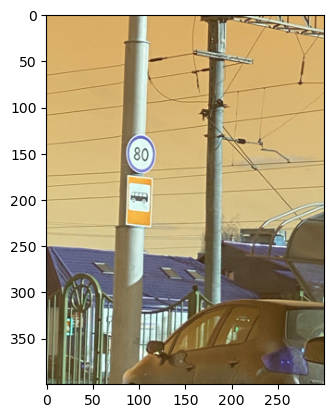

In [10]:
plt.imshow(im)

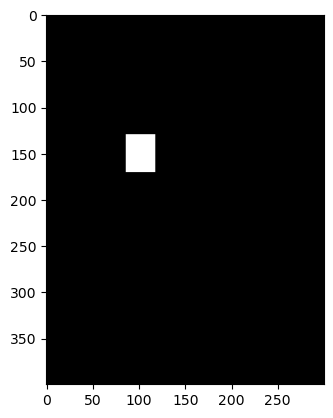

In [11]:
plt.imshow(Y, cmap='gray')

<h1> Data Augmentation </h1>

<p> Need to resize to prevent overfitting and to generalise the model better, while transforming need to make sure that the bounding box for each image also get transformed the same way <p>

In [12]:
# random crop to the original size
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=8):
    r, c, *_ = x.shape
    c_pix = round(r_pix * c / r)
    rand_r, rand_c = random.uniform(0, 1), random.uniform(0, 1)
    start_r, start_c = np.floor(2 * rand_r * r_pix).astype(int), np.floor(2 * rand_c * c_pix).astype(int)
    dr, dc = r - 2 * r_pix, c - 2 * c_pix
    return x[start_r:start_r + dr, start_c:start_c + dc]

def center_crop(x, r_pix=8):
    r, c, *_ = x.shape
    c_pix = round(r_pix * c / r)
    dr, dc = r - 2 * r_pix, c - 2 * c_pix
    return x[r_pix:r_pix + dr, c_pix:c_pix + dc]

In [13]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r, c, *_ = im.shape
    M = cv2.getRotationMatrix2D((c / 2, r / 2), deg, 1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS + interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    return x, create_box_from_mask(Y)

In [14]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

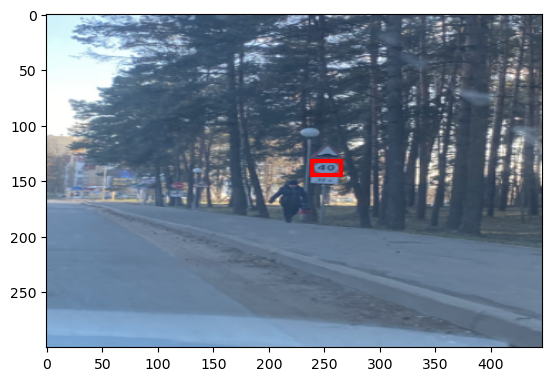

In [15]:
#original
im = cv2.imread(str(df_train.values[68][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[68][9])

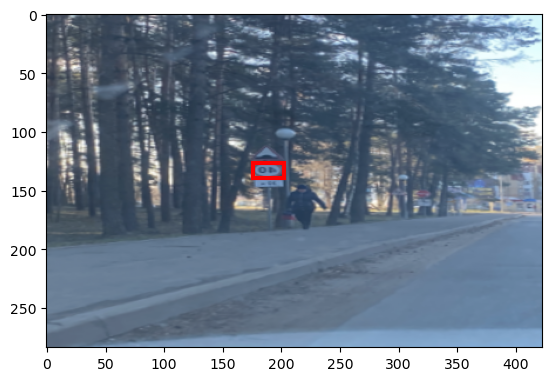

In [20]:
# after transformation
im, bb = transformsXY(str(df_train.values[68][8]), df_train.values[68][9], True)
show_corner_bb(im, bb)

<h1> Training </h1>

In [21]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [23]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [31]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [32]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34()
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [68]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        device = torch.device("cpu")
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.to(device).float()
            y_class = y_class.to(device)
            y_bb = y_bb.to(device).float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [69]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    device = torch.device("cpu")
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.to(device).float()  # Move input to CPU
        y_class = y_class.to(device)
        y_bb = y_bb.to(device).float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [93]:
model = BB_model()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.1)

In [73]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=5)

train_loss 9.100 val_loss 731928133.818 val_acc 0.057
train_loss 2.995 val_loss 63.888 val_acc 0.301
train_loss 1.847 val_loss 14.190 val_acc 0.136
train_loss 1.468 val_loss 8.995 val_acc 0.517
train_loss 1.022 val_loss 1.733 val_acc 0.653


1.021752111241753

In [94]:
PATH = './road_sign_model_1.pth'
torch.save(model.state_dict(), PATH)

<h1> Prediction </h1>

In [92]:
device = torch.device("cpu")
test_batch = next(iter(valid_dl))
out, bb = model(test_batch[0].to(device).float())

In [85]:
print('Class :', torch.argmax(out[0]).item())

Class : 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


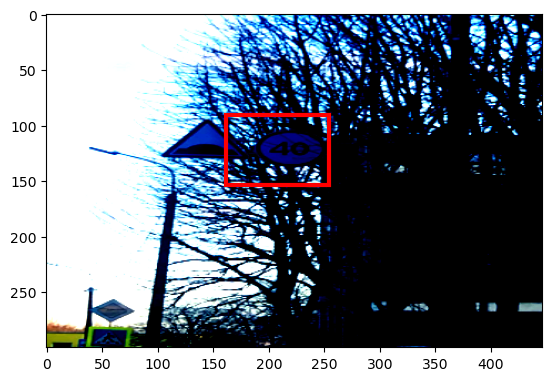

In [91]:
show_corner_bb(np.moveaxis(test_batch[0][0].detach().numpy(), 0, 2), bb[0].detach().numpy())